# Course Work - Facial Expression Recoginnision

Module: Computer Vision - INM460

By: Asha Guruvayurappan


## **Support Vector Machine with SIFT**



Implementing a series of image classification models using dataset from  https://forms.gle/P7jK9TThhUjvUuvi9

### Google Colab Setup
Before starting, we need to run a few commands to set up our environment on Google Colab. Also, if running this notebook on a local machine you can skip this section. 

The following cell is to mount the Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To update openCV

In [21]:
!pip install opencv-python==4.5.5.64

To check the version installed

In [3]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


The path in the Google Drive to access the folders and files

In [8]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Video', 'CW_Dataset', 'Code', 'Models', 'test_functions.ipynb']


### Data Loading

The dataset taken from the link is a ziped folder placed inside 'CW_Dataset'. The following lines of code will unzip the folder and create a copy named 'CW_Dataset-2'



In [6]:
# Identify path to zipped dataset

zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset', 'CW_Dataset-2.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset-2.zip

# Delete zipped version from Colab (not from Drive)
# !rm CW_Dataset-2.zip

### Importing Required libraries



In [1]:
from sklearn import svm, metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline


### Train-Data Loading

Images are in the format .jpg present in the folder that was unziped earlier, Each image from the folder is loaded using io.imread() and saved in a variable 'images'. These images re sorted in ascending order. 


The classes each image belong to is is a seperate text file in the format ==> *fileName classNumber* in each line. We read the text file and read each like to a list (stripping out newline). This is also sorted so that the order of images and lables align. The lables/class is the last string in each index position.





In [7]:
def import_training_data(path, folder, lable_list=None):
  """Load training images and lables from folders"""

  images =[]
  labels = []
  file_names = [file for file in sorted(os.listdir(os.path.join(path,folder))) if file.endswith('.jpg')]
  print(file_names)
  for file in file_names:
    images.append(io.imread(os.path.join(path, folder, file)))
  
  file_names = [file.replace('_aligned','') for file in file_names]
  
  return images, file_names
  


path = '/content/CW_Dataset-2'
images, file_names = import_training_data(path,'train')
print(file_names)


['train_00001_aligned.jpg', 'train_00002_aligned.jpg', 'train_00003_aligned.jpg', 'train_00004_aligned.jpg', 'train_00005_aligned.jpg', 'train_00006_aligned.jpg', 'train_00007_aligned.jpg', 'train_00008_aligned.jpg', 'train_00009_aligned.jpg', 'train_00010_aligned.jpg', 'train_00011_aligned.jpg', 'train_00012_aligned.jpg', 'train_00013_aligned.jpg', 'train_00014_aligned.jpg', 'train_00015_aligned.jpg', 'train_00016_aligned.jpg', 'train_00017_aligned.jpg', 'train_00018_aligned.jpg', 'train_00019_aligned.jpg', 'train_00020_aligned.jpg', 'train_00021_aligned.jpg', 'train_00022_aligned.jpg', 'train_00023_aligned.jpg', 'train_00024_aligned.jpg', 'train_00025_aligned.jpg', 'train_00026_aligned.jpg', 'train_00027_aligned.jpg', 'train_00028_aligned.jpg', 'train_00029_aligned.jpg', 'train_00030_aligned.jpg', 'train_00031_aligned.jpg', 'train_00032_aligned.jpg', 'train_00033_aligned.jpg', 'train_00034_aligned.jpg', 'train_00035_aligned.jpg', 'train_00036_aligned.jpg', 'train_00037_aligned.jpg', 

In [9]:
lables_path = os.path.join(path, 'labels')
file_labels= sorted(open(os.path.join(lables_path, 'list_label_train.txt'), "r").readlines())
# content_list = labels.readlines()
file_labels = [line.rstrip('\n') for line in file_labels]
print(file_labels)

labels = [label[-1] for label in file_labels]
print(labels)

['train_00001.jpg 5', 'train_00002.jpg 5', 'train_00003.jpg 4', 'train_00004.jpg 4', 'train_00005.jpg 5', 'train_00006.jpg 1', 'train_00007.jpg 5', 'train_00008.jpg 4', 'train_00009.jpg 4', 'train_00010.jpg 1', 'train_00011.jpg 4', 'train_00012.jpg 1', 'train_00013.jpg 1', 'train_00014.jpg 4', 'train_00015.jpg 5', 'train_00016.jpg 4', 'train_00017.jpg 4', 'train_00018.jpg 4', 'train_00019.jpg 4', 'train_00020.jpg 4', 'train_00021.jpg 4', 'train_00022.jpg 4', 'train_00023.jpg 6', 'train_00024.jpg 5', 'train_00025.jpg 5', 'train_00026.jpg 5', 'train_00027.jpg 2', 'train_00028.jpg 5', 'train_00029.jpg 4', 'train_00030.jpg 5', 'train_00031.jpg 3', 'train_00032.jpg 1', 'train_00033.jpg 5', 'train_00034.jpg 1', 'train_00035.jpg 4', 'train_00036.jpg 4', 'train_00037.jpg 4', 'train_00038.jpg 5', 'train_00039.jpg 5', 'train_00040.jpg 5', 'train_00041.jpg 5', 'train_00042.jpg 5', 'train_00043.jpg 1', 'train_00044.jpg 1', 'train_00045.jpg 4', 'train_00046.jpg 4', 'train_00047.jpg 6', 'train_00048

Check the count of each class

In [9]:
Counter(labels) 

Counter({'1': 1290,
         '2': 281,
         '3': 717,
         '4': 4772,
         '5': 1982,
         '6': 705,
         '7': 2524})

Class Imbalance

It can be noticed that few of the classess have fewer images when compared to other classes. This could leead to class imbalance probem at the time of testing as imbalanced data can skew the results 

In [10]:
!pip install imbalanced-learn

### Train and Validation Split

Train data is split into training data and validation data in order to get how the model performs in validation set. The test data is introduced only to the final best model, so to validate how the model is training we take 10% of train data as validation data



In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.1)

### SIFT

To extract a list of feature descriptors from each image, SIFT is used. These descriptors are then appended to a list called des_list which will be used to tune the model. 

*Adapted from : Computer vision Lab 07*





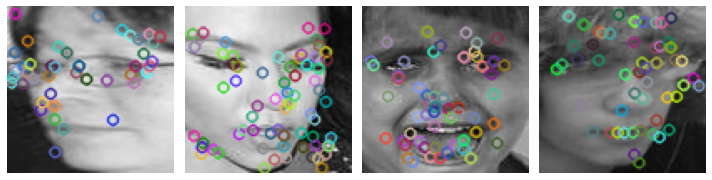

In [34]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

**Clustering of descriptors**

Now the descriptors are clustered, number of clusters k, is selected using the thumb rule - 10 times the number of classes. 

In [17]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(labels)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

In [35]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

DONT RUN BELOW CODE

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

### **Support Vector Machine**



*   Multiple models are created with different parameters to check the best set of parameters.
*   Grid search is used to tune hyperparameters. 
*   Accuracy on validation set is used as a metric to evaluate model performance




**SVM Model -1** 

SVM model is trained with cross validation with CV partition = 5, to avoid over fitting. 

*Adapted from : Computer vision Lab 07*


In [44]:
from sklearn.model_selection import cross_val_score

classifierCross = svm.SVC(kernel='rbf')

# We learn the digits on the first half of the digits

scores = cross_val_score(classifierCross, hist_array, y_train_list, cv=5, verbose=True)
# classifier.fit(hist_array, y_train_list)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [45]:
scores

array([0.40896739, 0.42572464, 0.42164855, 0.41096511, 0.42637064])

In [46]:
# We learn the digits on the first half of the digits
classifierCross.fit(hist_array, y_train_list)

SVC()

In [47]:
hist_list = []

for i in range(len(X_val)):
    img = img_as_ubyte(color.rgb2gray(X_val[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_val_ = [y_val[i] for i in idx_not_empty]
hist_array_val = np.vstack(hist_list)

In [48]:
y_val_pred = classifierCross.predict(hist_array_val).tolist()

In [49]:
print(classification_report(y_val_, y_val_pred))

              precision    recall  f1-score   support

           1       0.41      0.10      0.16       129
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        88
           4       0.46      0.87      0.60       493
           5       0.23      0.04      0.06       171
           6       0.00      0.00      0.00        74
           7       0.37      0.36      0.37       244

    accuracy                           0.44      1226
   macro avg       0.21      0.20      0.17      1226
weighted avg       0.33      0.44      0.34      1226



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM - Grid Search**

To tune different hyperparameters and get best model parameters

In [24]:
from sklearn.model_selection import GridSearchCV
import joblib

param_grid = {'C': [0.1, 1, 10 ],
              'kernel': ['linear','rbf']}
 
grid_SVM_model = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = True)

grid_SVM = grid_SVM_model.fit(hist_array, y_train_list)

print()
print("Best parameters set found on development set:")
print()
print(grid_SVM.best_params_)
joblib.dump(grid_SVM, GOOGLE_DRIVE_PATH + '/Models/GridSVM.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters set found on development set:

{'C': 1, 'kernel': 'rbf'}


['drive/My Drive/ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG/Models/GridSVM.pkl']

In [25]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf', C = 1)

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC(C=1)

In [37]:
hist_list = []

for i in range(len(X_val)):
    img = img_as_ubyte(color.rgb2gray(X_val[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_val_ = [y_val[i] for i in idx_not_empty]
hist_array_val = np.vstack(hist_list)

In [27]:
y_val_pred = classifier.predict(hist_array_val).tolist()

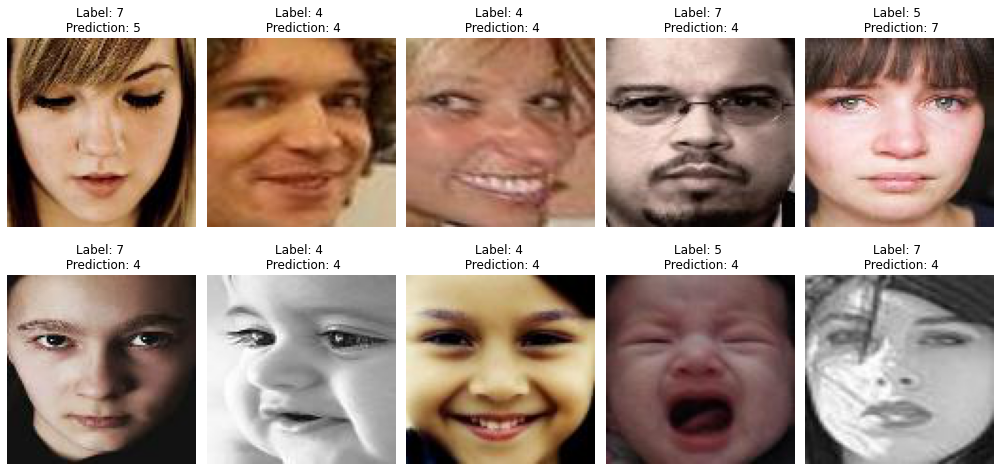

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_val[i])
    ax[i].set_title(f'Label: {y_val_[i]} \n Prediction: {y_val_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_val_, y_val_pred))

              precision    recall  f1-score   support

           1       0.41      0.10      0.16       129
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        88
           4       0.46      0.87      0.60       493
           5       0.23      0.04      0.06       171
           6       0.00      0.00      0.00        74
           7       0.37      0.36      0.37       244

    accuracy                           0.44      1226
   macro avg       0.21      0.20      0.17      1226
weighted avg       0.33      0.44      0.34      1226



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM Model - 2**



In [36]:
classifier_1 = svm.SVC(kernel='rbf', C = 1, max_iter= 1000, decision_function_shape = 'ovr', random_state=0, gamma = 'auto')

# We learn the digits on the first half of the digits
classifier_1.fit(hist_array, y_train_list)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(C=1, gamma='auto', max_iter=1000, random_state=0)

In [40]:
y_val_pred_1 = classifier_1.predict(hist_array_val).tolist()

In [41]:
print(classification_report(y_val_, y_val_pred_1))

              precision    recall  f1-score   support

           1       0.50      0.01      0.02       129
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        88
           4       1.00      0.01      0.01       493
           5       0.00      0.00      0.00       171
           6       0.00      0.00      0.00        74
           7       0.20      0.99      0.33       244

    accuracy                           0.20      1226
   macro avg       0.24      0.14      0.05      1226
weighted avg       0.49      0.20      0.07      1226



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
joblib.dump(classifier, GOOGLE_DRIVE_PATH + '/Models/SVM_Model_1.pkl')

['drive/My Drive/ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG/Models/SVM_Model_1.pkl']

In [43]:
joblib.dump(classifier_1, GOOGLE_DRIVE_PATH + '/Models/SVM_Model_2.pkl')

['drive/My Drive/ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG/Models/SVM_Model_2.pkl']

The best model of SVM is with Kernel - rgf and C = 1, the model is saved and can be used to test data

# Testing

In [18]:
images_test, file_names_test = import_training_data(path,'test')
print(file_names_test)

['test_0001_aligned.jpg', 'test_0002_aligned.jpg', 'test_0003_aligned.jpg', 'test_0004_aligned.jpg', 'test_0005_aligned.jpg', 'test_0006_aligned.jpg', 'test_0007_aligned.jpg', 'test_0008_aligned.jpg', 'test_0009_aligned.jpg', 'test_0010_aligned.jpg', 'test_0011_aligned.jpg', 'test_0012_aligned.jpg', 'test_0013_aligned.jpg', 'test_0014_aligned.jpg', 'test_0015_aligned.jpg', 'test_0016_aligned.jpg', 'test_0017_aligned.jpg', 'test_0018_aligned.jpg', 'test_0019_aligned.jpg', 'test_0020_aligned.jpg', 'test_0021_aligned.jpg', 'test_0022_aligned.jpg', 'test_0023_aligned.jpg', 'test_0024_aligned.jpg', 'test_0025_aligned.jpg', 'test_0026_aligned.jpg', 'test_0027_aligned.jpg', 'test_0028_aligned.jpg', 'test_0029_aligned.jpg', 'test_0030_aligned.jpg', 'test_0031_aligned.jpg', 'test_0032_aligned.jpg', 'test_0033_aligned.jpg', 'test_0034_aligned.jpg', 'test_0035_aligned.jpg', 'test_0036_aligned.jpg', 'test_0037_aligned.jpg', 'test_0038_aligned.jpg', 'test_0039_aligned.jpg', 'test_0040_aligned.jpg',

In [19]:
lables_path_test = os.path.join(path, 'labels')
file_labels_test= sorted(open(os.path.join(lables_path_test, 'list_label_test.txt'), "r").readlines())
# content_list = labels.readlines()
file_labels_test = [line.rstrip('\n') for line in file_labels_test]
print(file_labels_test)

labels_test = [label[-1] for label in file_labels_test]
print(labels_test)

['test_0001.jpg 5', 'test_0002.jpg 1', 'test_0003.jpg 4', 'test_0004.jpg 1', 'test_0005.jpg 5', 'test_0006.jpg 5', 'test_0007.jpg 3', 'test_0008.jpg 1', 'test_0009.jpg 4', 'test_0010.jpg 4', 'test_0011.jpg 3', 'test_0012.jpg 4', 'test_0013.jpg 4', 'test_0014.jpg 4', 'test_0015.jpg 1', 'test_0016.jpg 4', 'test_0017.jpg 6', 'test_0018.jpg 3', 'test_0019.jpg 4', 'test_0020.jpg 4', 'test_0021.jpg 4', 'test_0022.jpg 5', 'test_0023.jpg 1', 'test_0024.jpg 5', 'test_0025.jpg 4', 'test_0026.jpg 4', 'test_0027.jpg 6', 'test_0028.jpg 4', 'test_0029.jpg 4', 'test_0030.jpg 5', 'test_0031.jpg 5', 'test_0032.jpg 4', 'test_0033.jpg 4', 'test_0034.jpg 1', 'test_0035.jpg 1', 'test_0036.jpg 5', 'test_0037.jpg 6', 'test_0038.jpg 4', 'test_0039.jpg 5', 'test_0040.jpg 4', 'test_0041.jpg 4', 'test_0042.jpg 6', 'test_0043.jpg 1', 'test_0044.jpg 4', 'test_0045.jpg 5', 'test_0046.jpg 4', 'test_0047.jpg 4', 'test_0048.jpg 4', 'test_0049.jpg 5', 'test_0050.jpg 4', 'test_0051.jpg 4', 'test_0052.jpg 4', 'test_0053.

In [20]:
hist_list = []

for i in range(len(images_test)):
    img = img_as_ubyte(color.rgb2gray(images_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [labels_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [21]:
y_pred = classifier.predict(hist_array).tolist()

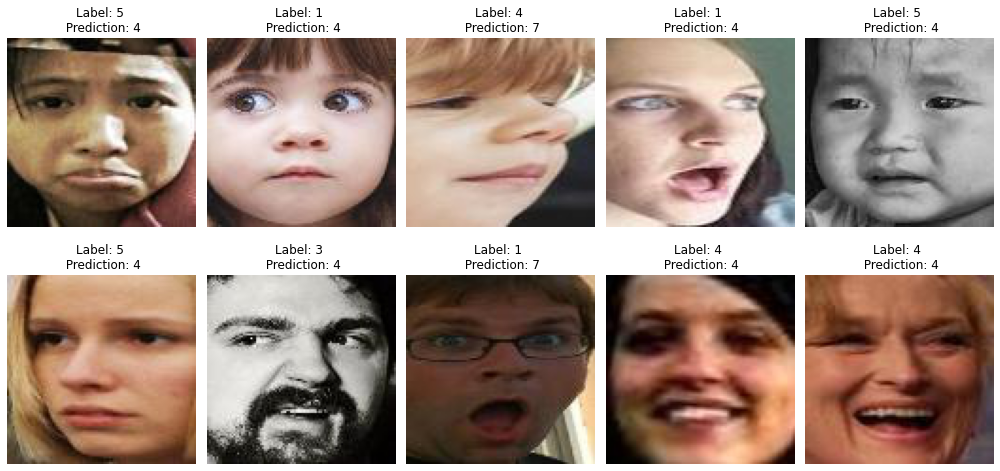

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(images_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [23]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.43      0.10      0.16       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.43      0.87      0.58      1184
           5       0.31      0.03      0.06       478
           6       0.00      0.00      0.00       162
           7       0.36      0.29      0.32       679

    accuracy                           0.42      3066
   macro avg       0.22      0.18      0.16      3066
weighted avg       0.34      0.42      0.32      3066




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
